In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader
from importlib import reload
import winsound
import dill, wandb, json,os
import datetime as dt
# if wandblog:
#     !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf

Notebook
GPU detected


In [4]:
with open('exp_compare/base.json') as file:
    construct_dict = json.load(file)

construct_dict['hyper_params']['hidden_states']=int(32)
construct_dict['data_params']['n_data']=int(2e5)   #just for tests, otherwise comment out  
construct_dict['data_params']['db_path']=construct_dict['data_params']['db_path'][3:]
construct_dict['data_params']['transform_path']=construct_dict['data_params']['transform_path'][3:]
construct_dict['group']='grad_tracker'

FileNotFoundError: [Errno 2] No such file or directory: 'exp_compare/base.json'

In [5]:
######
#dependencies
######

cwd=os.getcwd()
def get_lr_schedule(construct_dict):
    schedule  = construct_dict['run_params']['lr_schedule']
    lr_0        = construct_dict['run_params']['learning_rate']
    warm_up        = construct_dict['run_params']['warm_up']
    decay       = construct_dict['run_params']['lr_decay']

    import from_config.dev.lr_schedules as lr_module

    lr_generator = getattr(lr_module, schedule)

    lr_schedule  = lr_generator(lr_0, warm_up, decay)()

    return lr_schedule



def get_metrics(metric_name):
    # Returns a list of functions
    import from_config.dev.metrics as metrics
    metrics=getattr(metrics, metric_name)
    return metrics


def get_loss_func(name):
    # Return loss func from the loss functions file given a function name
    import from_config.dev.loss_funcs as loss_func_module
    loss_func = getattr(loss_func_module, name)
    return loss_func


def get_performance(name):
    # Return performance plotter from the eval_model file given a name
    import from_config.dev.eval_model as evals
    performance_plot = getattr(evals, name)
    return performance_plot 

def setup_model(construct_dict):
    # Retrieve name and params for construction
    model_name    = construct_dict['model_name']
    hyper_params  = construct_dict['hyper_params']
    experiment    = construct_dict['experiment']

    # Load model from model folder
    import from_config.dev.models as models
    model         = getattr(models, model_name) 
    model         = model(**hyper_params)

    # Make folder for saved states
    model_path    = osp.join(cwd, "trained_models", experiment)
    if not osp.isdir(model_path):
        os.makedirs(model_path)

    return model, model_path

In [6]:
def train_model(construct_dict):
    """
    Train a model given a construction dictionairy
    """

    # Setup Log 
    wandblog=construct_dict["wandblog"]
#     wandblog=0
    if wandblog:
        import wandb
        run = wandb.init(project = construct_dict["experiment"], entity = "chri862z", group=construct_dict["group"], config = construct_dict, reinit=True)
#         wandb.run.name = construct_dict['model_name']+'_'+construct_dict['experiment_name']+'_'+str(wandb.run.id)
        wandb.run.name = construct_dict['model_name']+'_'+str(wandb.run.id)
    ################################################
    #   Load dataset                              #
    ################################################
    from from_config.dev.data_load import graph_data
    #load dataset
    epochs      = construct_dict['run_params']['epochs']
    epochs=20
    batch_size  = construct_dict['run_params']['batch_size']
    
    dataset=graph_data(**construct_dict['data_params'])
    
    idx_lists = dataset.index_lists
    # Split data
    dataset_train = dataset[idx_lists[0]]
    dataset_val   = dataset[idx_lists[1]]
    dataset_test  = dataset[idx_lists[2]]

    loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size)
    loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
    loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)

     ###############################################
    #   Setup other run params                     #
    ################################################

    early_stop  = construct_dict['run_params']['early_stop']
    patience    = construct_dict['run_params']['patience']
    val_epoch = construct_dict['run_params']['val_epoch']

    print('check')
    ################################################
    #   Setup model, loss, lr schedule and metrics #
    ################################################

    # Get model, metrics, lr_schedule and loss function
    model, model_path     = setup_model(construct_dict)
    loss_func             = get_loss_func(construct_dict['run_params']['loss_func'])
    metrics               = get_metrics(construct_dict['run_params']['metrics'])
    performance_plot      = get_performance(construct_dict['run_params']['performance_plot'])
    lr_schedule          = get_lr_schedule(construct_dict)
    save_path=osp.join(model_path,wandb.run.name)

    if not osp.isdir(save_path):
        os.makedirs(save_path)
        print('New folder for saving run made')

    # Learning rate and optimizer
    learning_rate            = next(lr_schedule)
    opt           = Adam(learning_rate)

    ################################################
    #   Set up TF functions and validation step   #
    ################################################


    # Define training function
    @tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training = True)
            targets     = tf.cast(targets, tf.float32)
            loss        = loss_func(predictions, targets)
            loss       += sum(model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    @tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
    def test_step(inputs, targets):
        predictions = model(inputs, training = False)
        targets     = tf.cast(targets, tf.float32) 
        out         = loss_func(predictions, targets)

        return predictions, targets, out


    def validation(loader):
        loss = 0
        prediction_list, target_list = [], []
        for batch in loader:
            inputs, targets = batch
            predictions, targets, out = test_step(inputs, targets)
            loss           += out
            
            prediction_list.append(predictions)
            target_list.append(targets)
        
        y_reco  = tf.concat(prediction_list, axis = 0)
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32)

        loss, loss_from = loss_func(y_reco, y_true, re=True)
        
        energy, e_old, alpha, zeni, azi= metrics(y_reco, y_true)
        
        return loss, loss_from, [energy, e_old, alpha, zeni, azi]

    # Define grad tracking function
    @tf.function(experimental_relax_shapes = True)
    def gradient_importance(inputs, targets, j):
        with tf.GradientTape() as tape:
            tape.watch(inputs[0])
            predictions = model(inputs, training=False)[:,j] # needs to be under the gradient tape to be tracked

        grads = tape.gradient(predictions, inputs[0])
        grads=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)

        grads=tf.math.segment_mean(tf.math.abs(grads), inputs[2], name=None)
        return grads

    ################################################
    #  Train Model                                 #      
    ################################################
    j=0
    tot_time=0
    current_batch = 0
    current_epoch = 1
    loss          = 0
    lowest_loss   = np.inf
    early_stop    = 1
    early_stop_counter    = 0
    pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)
    start_time    = time.time()
    summarylist=[]
    for batch in loader_train:
        inputs, targets = batch
        out             = train_step(inputs, targets)
        loss           += out
        if current_epoch==1 and current_batch==0:
            model.summary()
            if wandblog:
                summary=model.summary(print_fn=summarylist.append)
                table=wandb.Table(columns=["Layers"])
                for s in summarylist:
                    table.add_data(s)
                wandb.log({'Model summary': table})
        current_batch  += 1
        pbar.update(1)
        pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
        
        if current_batch == loader_train.steps_per_epoch:
            t=time.time() - start_time
            tot_time+=t
            print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
            print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

            loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
            val_loss, val_loss_from, val_metric = validation(loader_val)
#             if wandblog:
#                 wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
#                         "Validation Loss": val_loss, 
#                         "w(log(E))":   val_metric[1],
#                         "Energy bias":   val_metric[0][1],
#                         "Solid angle 68th":    val_metric[2][3],
#                         "Angle bias":   val_metric[2][1],
#                         "zenith 68th":    val_metric[3][3],
#                         "zenith bias":   val_metric[3][1],
#                         "azimuth 68th":    val_metric[4][3],
#                         "azimuth bias":   val_metric[4][1]})
            grad_dict={'energy':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1},
                       'zenith':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1},
                      'azimuth':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1},
                      'sig_zeni':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1},
                      'sig_azi':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1}}
            keys=list(grad_dict.keys())
            feats=list(grad_dict[keys[0]].keys())
            for j in range(len(keys)):  
                grads=gradient_importance(inputs, targets, j)
                grads_av=tf.reduce_mean(grads, axis=0)
                grads_av=grads_av/tf.reduce_sum(grads_av) #softmax
                for i, feat in enumerate(feats):
                    grad_dict[keys[j]][feat]=grads_av[i]
            if wandblog:
                wandb.log(grad_dict)
                
            if not construct_dict['run_params']['zeniazi_metric']:
                print(f"Avg loss of validation: {val_loss:.6f}")
                print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
                print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[1]:.6f}\
                    \n Angle: bias = {val_metric[2][1]:.6f} sig_range = {val_metric[2][0]:.6f}<->{val_metric[2][2]:.6f}, old metric {val_metric[2][3]:.6f}")
            else:
                print(f"Avg loss of validation: {val_loss:.6f}")
                print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
                print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[1]:.6f}\
                    \n Angle: bias = {val_metric[2][1]:.6f} sig_range = {val_metric[2][0]:.6f}<->{val_metric[2][2]:.6f}, old metric {val_metric[2][3]:.6f}\
                    \n Zenith: bias = {val_metric[3][1]:.6f} sig_range = {val_metric[3][0]:.6f}<->{val_metric[3][2]:.6f}, old metric {val_metric[3][3]:.6f}\
                    \n Azimuth: bias = {val_metric[4][1]:.6f} sig_range = {val_metric[4][0]:.6f}<->{val_metric[4][2]:.6f}, old metric {val_metric[4][3]:.6f}")

            if val_loss < lowest_loss:
                early_stop_counter = 0
                lowest_loss        = val_loss
            else:
                early_stop_counter += 1
            print(f'Early stop counter: {early_stop_counter}/{patience}, lowest val loss was {lowest_loss:.6f}')
            if early_stop and (early_stop_counter >= patience):
                model.save(save_path)
                print(f"Stopped training. No improvement was seen in {patience} epochs")
#                 return current_epoch

            if current_epoch != epochs:
                pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)

            learning_rate = next(lr_schedule)
            opt.learning_rate.assign(learning_rate)

            time_avg=tot_time/current_epoch
            if current_epoch % val_epoch == 0:
                model.save(save_path)
                print("Model saved")
                if wandblog:
                    loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
                    fig, _ = performance_plot(loader_test, test_step, metrics, save=True, save_path=save_path)
                    title="performanceplot_"+str(current_epoch)
                    wandb.log({title: [wandb.Image(fig, caption=title)]})
        
            loss            = 0
            start_time      = time.time()
            current_epoch  += 1
            current_batch   = 0
    return grad_list, grad_mean
    

wandb: Currently logged in as: chri862z (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Not notebook
Connecting to db-file
Loading Muons
Reading files


C:\Users\chris\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Splitting data to events


  0%|                                                                             | 73/200000 [00:00<04:35, 724.72it/s]

     dom_x    dom_y    dom_z      time  charge_log10  SRTInIcePulses
0 -0.25614 -0.52108  0.29178 -0.902557     -0.088028               0
1  0.50527  0.25788 -0.20864 -1.099296      0.378965               0
2 -0.06670  0.27692  0.00422  0.424602      0.791982               0
3  0.30341  0.33564  0.03637 -0.125602      1.160970               0
4  0.30341  0.33564  0.03637 -0.114116     -1.656923               0
   energy_log10    zenith   azimuth
0      2.422178  0.914194  0.967663
1      2.311812  1.155833  5.953112
2      3.433424  1.205342  2.802480
3      2.582473  0.518382  4.915968
4      2.783172  0.709137  5.187095
Generating adjacency matrices


100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [02:30<00:00, 1325.13it/s]


Saving dataset
Loading data to memory
check
loading model
New folder for saving run made


Model: "sage"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
mp (MP)                      multiple                  17056     
_________________________________________________________________
graph_sage_conv (GraphSageCo multiple                  4096      
_________________________________________________________________
graph_sage_conv_1 (GraphSage multiple                  16384     
_________________________________________________________________
global_max_pool (GlobalMaxPo multiple                  0         
_________________________________________________________________
global_avg_pool (GlobalAvgPo multiple                  0         
_________________________________________________________________
global_sum_pool (GlobalSumPo multiple                  0      


Epoch 2 of 20 done in 388.86 seconds using learning rate: 2.50E-04
Avg loss of train: 1.034854
Avg loss of validation: -0.172424
Loss from:  Energy: 0.225795 	 Angle: -1.090954 
Energy: bias = 0.164714 sig_range = 0.048996<->0.396667, old metric 0.240987                    
 Angle: bias = 39.404346 sig_range = 17.839144<->73.167801, old metric 53.943146                    
 Zenith: bias = 8.441315 sig_range = 2.535703<->18.367294, old metric 12.600336                    
 Azimuth: bias = 67.920128 sig_range = 19.604801<->133.002640, old metric 99.436234
Early stop counter: 0/5, lowest val loss was -0.172424



Epoch 3 of 20 done in 385.10 seconds using learning rate: 5.00E-04
Avg loss of train: 0.183179
Avg loss of validation: -0.106474
Loss from:  Energy: 0.257809 	 Angle: -0.945351 
Energy: bias = 0.205990 sig_range = 0.064389<->0.437549, old metric 0.215608                    
 Angle: bias = 31.165514 sig_range = 14.429235<->58.283630, old metric 42.376663                    
 Zenith: bias = 8.640203 sig_range = 2.561984<->18.527357, old metric 12.943715                    
 Azimuth: bias = 50.961243 sig_range = 15.014900<->111.709915, old metric 77.478127
Early stop counter: 1/5, lowest val loss was -0.172424


Epoch 4 of 20 done in 390.37 seconds using learning rate: 1.00E-03
Avg loss of train: -0.350679
Avg loss of validation: -0.703596
Loss from:  Energy: 0.196629 	 Angle: -1.175445 
Energy: bias = 0.151793 sig_range = 0.045354<->0.333526, old metric 0.215527                    
 Angle: bias = 24.931044 sig_range = 11.465079<->48.823914, old metric 34.561275                    
 Zenith: bias = 8.349350 sig_range = 2.541817<->17.496811, old metric 12.272555                    
 Azimuth: bias = 35.998787 sig_range = 9.878120<->102.795540, old metric 59.827812
Early stop counter: 0/5, lowest val loss was -0.703596


Epoch 5 of 20 done in 398.16 seconds using learning rate: 9.00E-04
Avg loss of train: -0.779165
Avg loss of validation: -0.842819
Loss from:  Energy: 0.194630 	 Angle: -1.178951 
Energy: bias = 0.139108 sig_range = 0.040346<->0.340407, old metric 0.206504                    
 Angle: bias = 22.105654 sig_range = 10.202011<->46.869987, old metric 31.541115                    
 Zenith: bias = 8.485847 sig_range = 2.600866<->17.320745, old metric 12.344033                    
 Azimuth: bias = 30.507149 sig_range = 8.303843<->93.285088, old metric 51.362572
Early stop counter: 0/5, lowest val loss was -0.842819


Epoch 6 of 20 done in 398.55 seconds using learning rate: 8.10E-04
Avg loss of train: -0.991353
Avg loss of validation: -1.017982
Loss from:  Energy: 0.184661 	 Angle: -1.299903 
Energy: bias = 0.137348 sig_range = 0.039869<->0.328075, old metric 0.194568                    
 Angle: bias = 19.163624 sig_range = 8.445874<->40.597275, old metric 27.571894                    
 Zenith: bias = 7.283687 sig_range = 2.115350<->16.426838, old metric 11.135990                    
 Azimuth: bias = 28.591745 sig_range = 7.743385<->89.200676, old metric 47.856815
Early stop counter: 0/5, lowest val loss was -1.017982






Epoch 7 of 20 done in 398.45 seconds using learning rate: 7.29E-04
Avg loss of train: -1.078379
Avg loss of validation: -1.053509
Loss from:  Energy: 0.190797 	 Angle: -1.325493 
Energy: bias = 0.150443 sig_range = 0.044556<->0.319899, old metric 0.219590                    
 Angle: bias = 19.674990 sig_range = 9.034116<->41.477699, old metric 27.755550                    
 Zenith: bias = 7.221952 sig_range = 2.115835<->15.624984, old metric 10.757934                    
 Azimuth: bias = 28.750807 sig_range = 7.999436<->87.209671, old metric 47.270184
Early stop counter: 0/5, lowest val loss was -1.053509


Epoch 8 of 20 done in 379.60 seconds using learning rate: 6.56E-04
Avg loss of train: -1.181104
Avg loss of validation: -1.121220
Loss from:  Energy: 0.176878 	 Angle: -1.399607 
Energy: bias = 0.119869 sig_range = 0.034786<->0.311466, old metric 0.194668                    
 Angle: bias = 19.718094 sig_range = 8.848331<->41.795116, old metric 28.080576                    
 Zenith: bias = 6.847022 sig_range = 2.021267<->14.671616, old metric 10.227054                    
 Azimuth: bias = 29.732660 sig_range = 8.005637<->98.067268, old metric 51.422035
Early stop counter: 0/5, lowest val loss was -1.121220


Epoch 9 of 20 done in 380.65 seconds using learning rate: 5.90E-04
Avg loss of train: -1.209305
Avg loss of validation: -1.227795
Loss from:  Energy: 0.171996 	 Angle: -1.432429 
Energy: bias = 0.129281 sig_range = 0.038205<->0.298054, old metric 0.191892                    
 Angle: bias = 17.534643 sig_range = 7.742733<->37.552765, old metric 24.855539                    
 Zenith: bias = 6.362710 sig_range = 1.815118<->13.996017, old metric 9.563696                    
 Azimuth: bias = 27.770565 sig_range = 7.378407<->94.460793, old metric 47.814083
Early stop counter: 0/5, lowest val loss was -1.227795


Epoch 10 of 20 done in 346.15 seconds using learning rate: 5.31E-04
Avg loss of train: -1.321400
Avg loss of validation: -1.336246
Loss from:  Energy: 0.182301 	 Angle: -1.488412 
Energy: bias = 0.123561 sig_range = 0.035661<->0.323454, old metric 0.198097                    
 Angle: bias = 16.667881 sig_range = 7.352526<->36.847710, old metric 24.102251                    
 Zenith: bias = 6.157061 sig_range = 1.834473<->13.824173, old metric 9.335403                    
 Azimuth: bias = 24.705246 sig_range = 6.495360<->89.040329, old metric 43.648666
Early stop counter: 0/5, lowest val loss was -1.336246






INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\trained_models\IceCube\Sage_50cjbihi\assets
Model saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch 11 of 20 done in 357.26 seconds using learning rate: 4.78E-04
Avg loss of train: -1.320145
Avg loss of validation: -0.998872
Loss from:  Energy: 0.170113 	 Angle: -1.146809 
Energy: bias = 0.125198 sig_range = 0.036860<->0.293647, old metric 0.182311                    
 Angle: bias = 17.710079 sig_range = 8.259921<->35.791603, old metric 24.695642                    
 Zenith: bias = 7.910678 sig_range = 2.369396<->17.039776, old metric 11.857102                    
 Azimuth: bias = 27.007826 sig_range = 7.205494<->84.517883, old metric 46.214493
Early stop counter: 1/5, lowest val loss was -1.336246


Epoch 12 of 20 done in 352.41 seconds using learning rate: 4.30E-04
Avg loss of train: -1.377971
Avg loss of validation: -1.329044
Loss from:  Energy: 0.160143 	 Angle: -1.384221 
Energy: bias = 0.115878 sig_range = 0.035212<->0.274513, old metric 0.168465                    
 Angle: bias = 15.780172 sig_range = 7.052742<->34.279205, old metric 22.677706                    
 Zenith: bias = 6.094103 sig_range = 1.780528<->13.560688, old metric 9.164068                    
 Azimuth: bias = 23.728153 sig_range = 6.502176<->77.673462, old metric 40.512154
Early stop counter: 2/5, lowest val loss was -1.336246


Epoch 13 of 20 done in 348.93 seconds using learning rate: 3.87E-04
Avg loss of train: -1.428085
Avg loss of validation: -1.402532
Loss from:  Energy: 0.158959 	 Angle: -1.402547 
Energy: bias = 0.110668 sig_range = 0.031513<->0.279858, old metric 0.168112                    
 Angle: bias = 15.534089 sig_range = 6.982328<->32.740685, old metric 21.881435                    
 Zenith: bias = 6.594114 sig_range = 1.950528<->14.864114, old metric 10.080574                    
 Azimuth: bias = 22.152393 sig_range = 5.941049<->74.905022, old metric 38.268620
Early stop counter: 0/5, lowest val loss was -1.402532


Epoch 14 of 20 done in 343.57 seconds using learning rate: 3.49E-04
Avg loss of train: -1.470248
Avg loss of validation: -1.538010
Loss from:  Energy: 0.162164 	 Angle: -1.540928 
Energy: bias = 0.117315 sig_range = 0.033918<->0.280204, old metric 0.177421                    
 Angle: bias = 15.185616 sig_range = 6.653489<->34.283852, old metric 21.956169                    
 Zenith: bias = 5.752192 sig_range = 1.678261<->13.040009, old metric 8.765510                    
 Azimuth: bias = 22.539433 sig_range = 5.827545<->78.982857, old metric 39.194660
Early stop counter: 0/5, lowest val loss was -1.538010


Epoch 15 of 20 done in 340.30 seconds using learning rate: 3.14E-04
Avg loss of train: -1.508500
Avg loss of validation: -1.635082
Loss from:  Energy: 0.156349 	 Angle: -1.596529 
Energy: bias = 0.114910 sig_range = 0.033694<->0.268246, old metric 0.166653                    
 Angle: bias = 14.583732 sig_range = 6.528316<->33.096382, old metric 21.248701                    
 Zenith: bias = 5.565972 sig_range = 1.640106<->12.569509, old metric 8.426396                    
 Azimuth: bias = 21.553698 sig_range = 5.956690<->70.297661, old metric 36.181023
Early stop counter: 0/5, lowest val loss was -1.635082







Epoch 16 of 20 done in 334.65 seconds using learning rate: 2.82E-04
Avg loss of train: -1.546111
Avg loss of validation: -1.510874
Loss from:  Energy: 0.158491 	 Angle: -1.480775 
Energy: bias = 0.116542 sig_range = 0.033345<->0.275769, old metric 0.169186                    
 Angle: bias = 14.422626 sig_range = 6.443207<->31.820223, old metric 20.928782                    
 Zenith: bias = 5.895167 sig_range = 1.750716<->13.260857, old metric 8.946665                    
 Azimuth: bias = 21.440346 sig_range = 5.767050<->73.542107, old metric 37.424164
Early stop counter: 1/5, lowest val loss was -1.635082


Epoch 17 of 20 done in 339.56 seconds using learning rate: 2.54E-04
Avg loss of train: -1.584278
Avg loss of validation: -1.674175
Loss from:  Energy: 0.155333 	 Angle: -1.612717 
Energy: bias = 0.106317 sig_range = 0.030879<->0.275952, old metric 0.167345                    
 Angle: bias = 14.314293 sig_range = 6.236557<->32.479034, old metric 20.918615                    
 Zenith: bias = 5.485629 sig_range = 1.599135<->12.415071, old metric 8.311179                    
 Azimuth: bias = 21.121431 sig_range = 5.678264<->73.551437, old metric 36.779396
Early stop counter: 0/5, lowest val loss was -1.674175


Epoch 18 of 20 done in 335.43 seconds using learning rate: 2.29E-04
Avg loss of train: -1.613556
Avg loss of validation: -1.677928
Loss from:  Energy: 0.153732 	 Angle: -1.601576 
Energy: bias = 0.111611 sig_range = 0.031951<->0.262196, old metric 0.168237                    
 Angle: bias = 14.394327 sig_range = 6.349496<->32.184708, old metric 20.887728                    
 Zenith: bias = 5.446908 sig_range = 1.626386<->12.472425, old metric 8.340337                    
 Azimuth: bias = 20.619167 sig_range = 5.614211<->73.721100, old metric 36.551102
Early stop counter: 0/5, lowest val loss was -1.677928


Epoch 19 of 20 done in 336.39 seconds using learning rate: 2.06E-04
Avg loss of train: -1.633327
Avg loss of validation: -1.531781
Loss from:  Energy: 0.163430 	 Angle: -1.460678 
Energy: bias = 0.127859 sig_range = 0.039932<->0.279761, old metric 0.169150                    
 Angle: bias = 15.546503 sig_range = 6.925803<->34.331593, old metric 22.553577                    
 Zenith: bias = 6.401557 sig_range = 1.841215<->14.445481, old metric 9.777529                    
 Azimuth: bias = 20.924940 sig_range = 5.581398<->74.428955, old metric 35.868561
Early stop counter: 1/5, lowest val loss was -1.677928


Epoch 20 of 20 done in 337.60 seconds using learning rate: 1.85E-04
Avg loss of train: -1.650234
Avg loss of validation: -1.740643
Loss from:  Energy: 0.151582 	 Angle: -1.624471 
Energy: bias = 0.110608 sig_range = 0.032877<->0.259519, old metric 0.163935                    
 Angle: bias = 14.151193 sig_range = 6.196124<->31.968479, old metric 20.578938                    
 Zenith: bias = 5.411313 sig_range = 1.597421<->12.243093, old metric 8.231806                    
 Azimuth: bias = 20.305538 sig_range = 5.618719<->69.329582, old metric 35.340343
Early stop counter: 0/5, lowest val loss was -1.740643




INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\trained_models\IceCube\Sage_50cjbihi\assets
Model saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


NameError: name 'grad_list' is not defined

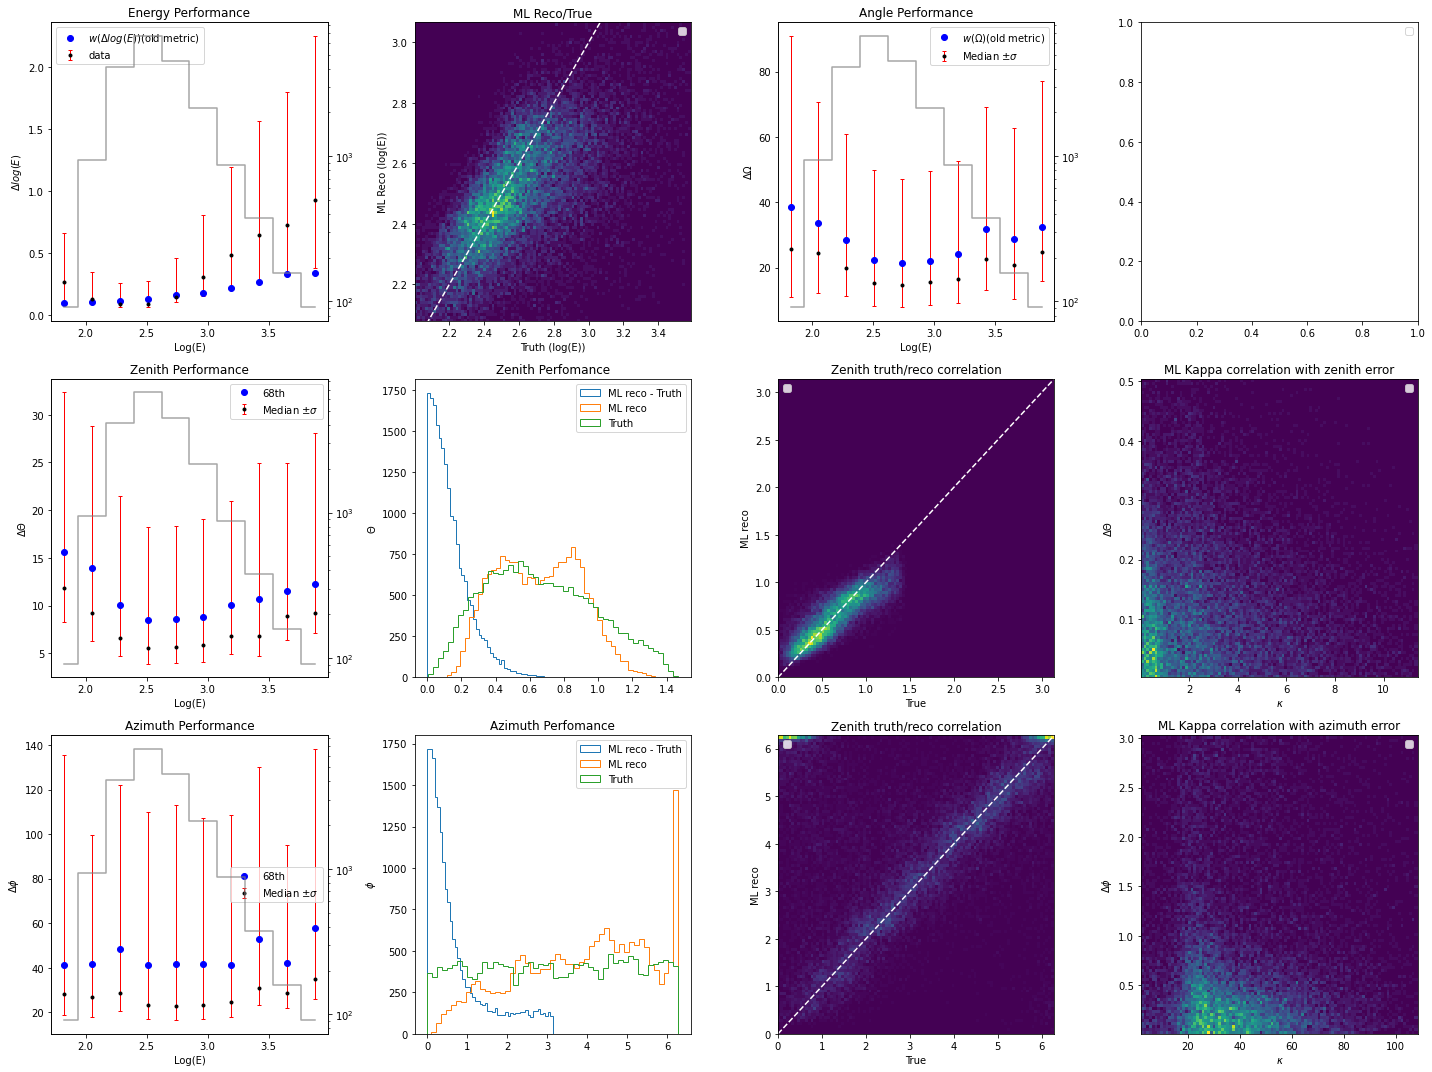

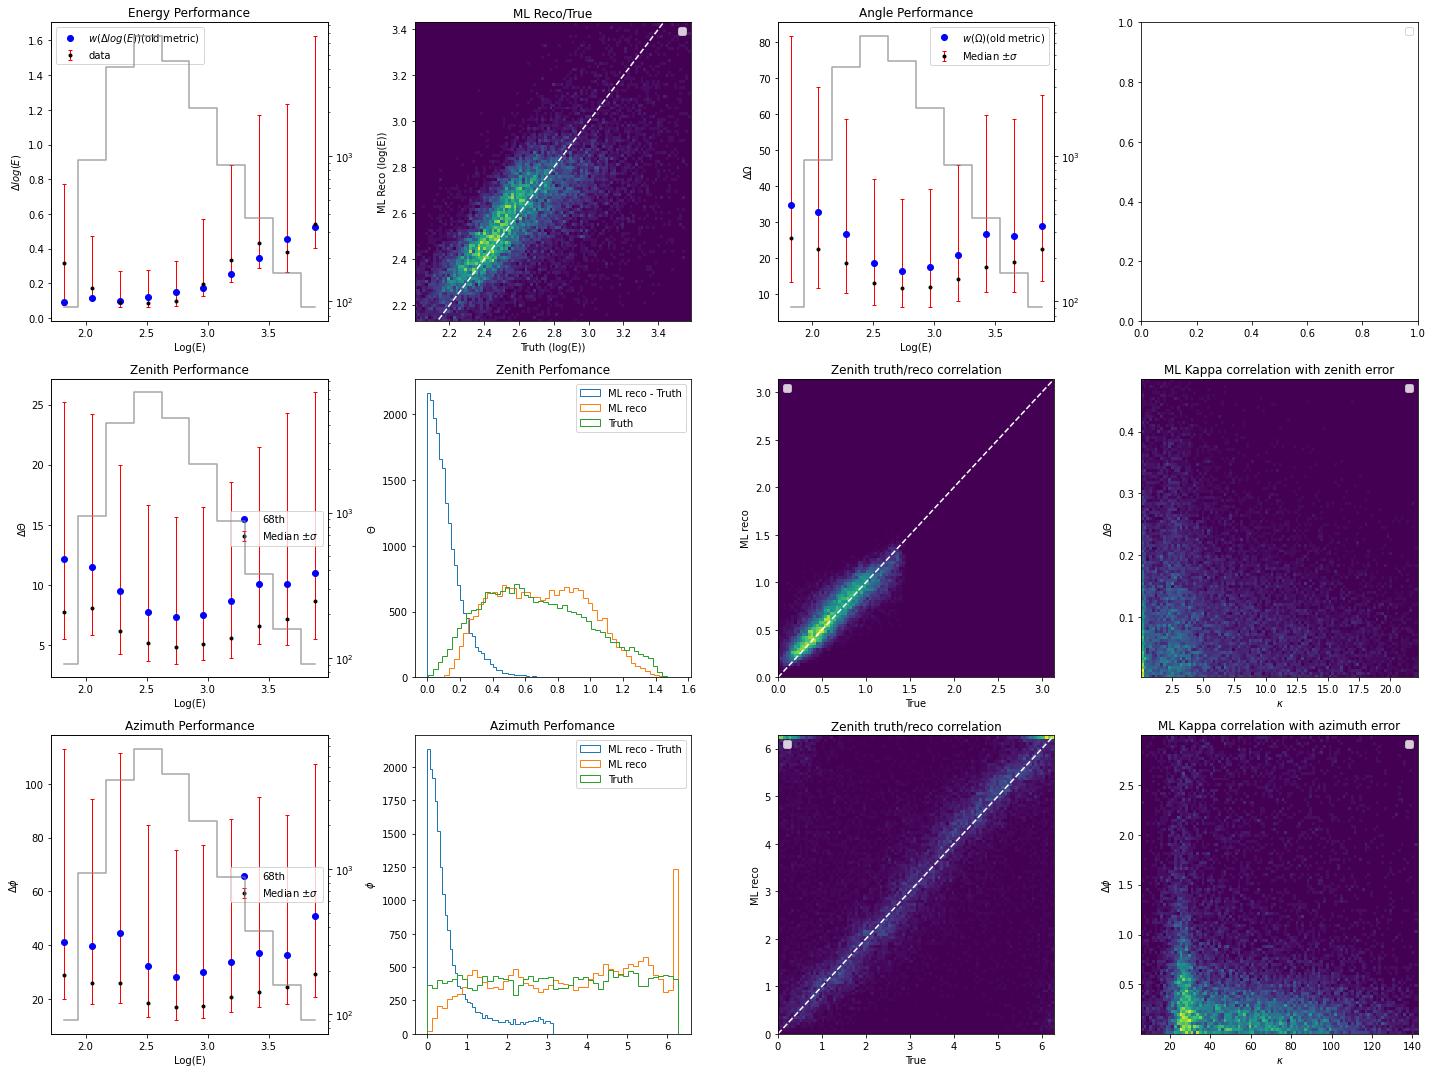

In [7]:
full, means=train_model(construct_dict)

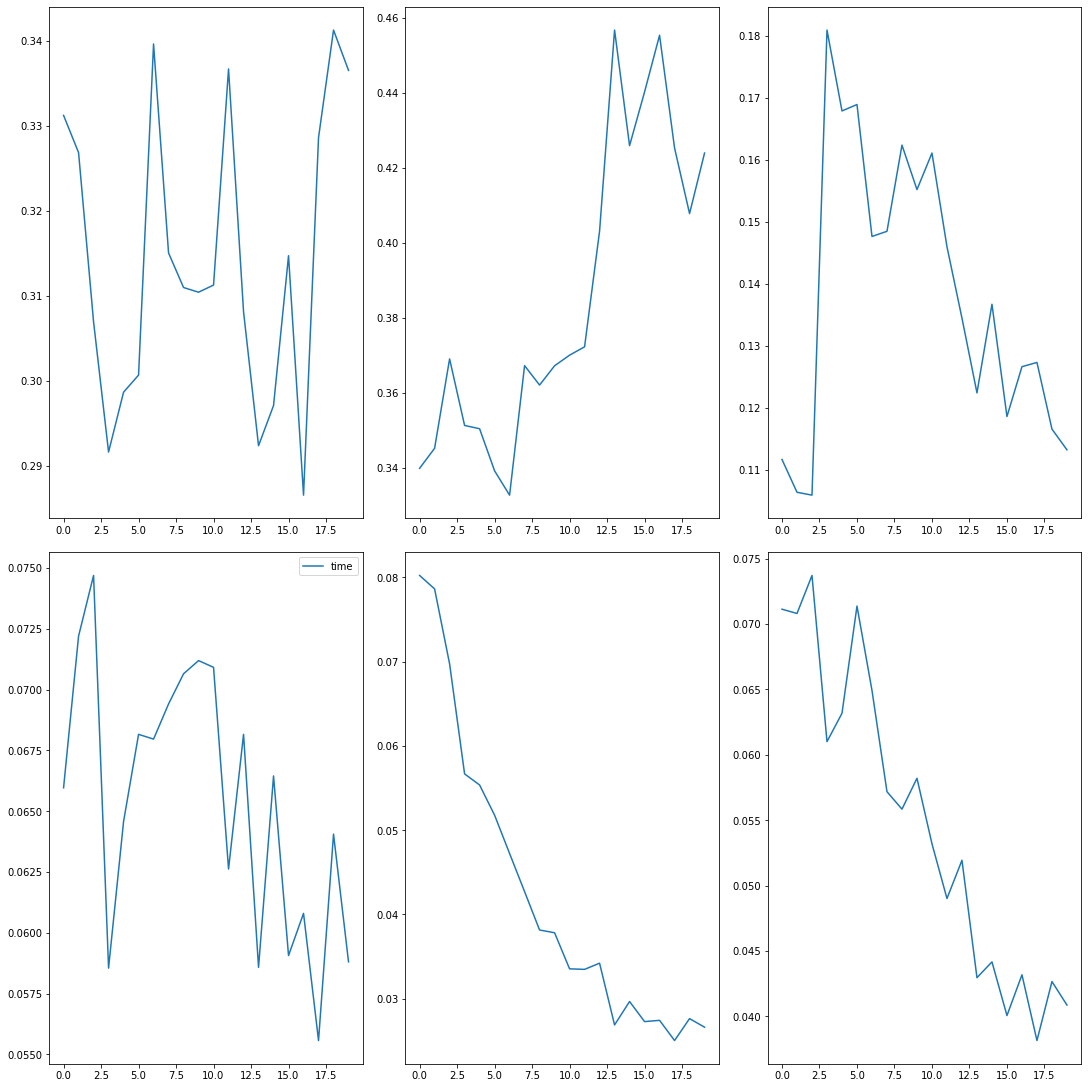

In [31]:
domx=summary[:,0]

ax = plt.figure(constrained_layout=True, figsize=(15,15)).subplot_mosaic(
    [['dom_x', 'dom_y', 'dom_z'],
    ['time', 'charge', 'SRT']])

ax['dom_x'].plot(summary[:,0],label='dom_x')
ax['dom_y'].plot(summary[:,1], label='dom_y')
ax['dom_z'].plot(summary[:,2], label='dom_z')
ax['time'].plot(summary[:,3], label='time')
ax['charge'].plot(summary[:,4], label='charge')
ax['SRT'].plot(summary[:,5], label='SRT')
plt.legend()

In [37]:
grad_dict={'energy':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
           'zenith':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'azimuth':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_zeni':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_azi':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1}}

In [46]:
feats=list(grad_dict[keys[0]].keys())